In [1]:
import os
import music21 as ms
import numpy as np
import torch
import torch.nn as nn
from encoder_decoder import encode, decode
import matplotlib.pyplot as plt
  
def get_right_hand(midi_file, time_step=0.05):
    
    hands = ms.converter.parse(midi_file)
    voice = False  # If there is more than one voice on
    for idx, nt in enumerate(hands[0]):  # the right hand (first part), just
        if type(nt) == ms.stream.Voice:  # takes the first voice
            voice = True
            break
    if voice:
        right_notes = encode(hands[0][idx], time_step=time_step)
    else:
        right_notes = encode(hands[0], time_step=time_step)
        
    return right_notes
  
# Reads a MIDI file
path = os.getcwd()[:-4] + "Data/classical/bach/unknown/bach_846.mid"
bach = ms.converter.parse(path)
# Encodes the first hand of bach
notes_encoded = get_right_hand(path, time_step=0.25)
notes_encoded = notes_encoded[:, :-1]

notes_encoded = torch.from_numpy(notes_encoded.reshape(-1, 1, 89)).float()
notes_encoded.shape  # [seq_len, batch_size, input_size]

torch.Size([1120, 1, 89])

In [2]:
# Code modified from https://github.com/amir-jafari/Deep-Learning/blob/master/Pytorch_/7-RNN/1_RNN.py

class LSTMMusic(nn.Module):
    
    def __init__(self, input_size, hidden_size):
            
        super(LSTMMusic, self).__init__()
        # Input of shape (seq_len, batch_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size)
        # Fully connected Layer at the end, output_size=input_size because we want to predict
        self.out = nn.Linear(hidden_size, input_size)  # the next note/sequence of notes
        # We use a sigmoid activation function instead of the usual softmax
        # because we want to predict potentially more than one label per vector,
        # like for example, when we have a hold or a chord
        # Idea from: https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/
        self.act = nn.Sigmoid()
    
    def forward(self, x, h_c_state):
        
        y_pred, h_c_state = self.lstm(x, h_c_state)
        return self.act(self.out(y_pred)), h_c_state 

# Hidden size needs to be equal to input_size
net = LSTMMusic(89, 89) # because we want to predict the next note/sequence of notes
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_func = nn.BCELoss()  # Because we are using sigmoid and not softmax, BCELoss is the right choice
h_state = torch.zeros(1, 1, 89).float()  # Initializes the hidden
c_state = torch.zeros(1, 1, 89).float()  # and cell states
seq_len = 1  # We will take as input only the previous not
l = []  # Stores the loss per sequence
lll = []  # Idem, but will be set to [] after each epoch for ll
ll = []  # Stores the mean loss per epoch
wait_10 = 0  # We will halve the learning rate if the loss does not decrease in the last 10 epochs
for epoch in range(100):
    print("---------- epoch number:", epoch, "----------")
    for step in range(notes_encoded.shape[0]//seq_len - 1):
        x = notes_encoded[step:seq_len+step, :, :]  # We take as input the last seq_len notes
        x.requires_grad = True
        y = notes_encoded[step+seq_len:step+seq_len*2, :, :]  # Uses the whole next sequence to get the loss
        #y = notes_encoded[step+seq_len, :, :]                # Uses only the next note after input sequence to get the loss
        y_pred, h_c_state = net(x, (h_state, c_state))  
        #y_pred = y_pred[0]                                      # Uses only the next note after input sequence to get the loss
        # y_pred shape: [seq_len, batch_size, hidden_size]
        h_state, c_state = h_c_state[0].data, h_c_state[1].data  # repack the hidden state, break the connection from last iteration
        loss = loss_func(y_pred, y)
        l.append(loss.data)
        lll.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ll.append(np.mean(lll))
    print("           loss:", ll[-1])
    if ll[-1] > np.mean(ll[::-1][:10]) and wait_10 >= 10:  # We decrease the learning rate by half
        print("Halving learning rate from", lr, "to", lr/2)  # When the loss stops decreasing
        lr = lr/2
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        wait_10 = 0
    lll = []
    wait_10 += 1

---------- epoch number: 0 ----------
           loss: 0.028459642
---------- epoch number: 1 ----------
           loss: 0.02007095
---------- epoch number: 2 ----------
           loss: 0.017473033
---------- epoch number: 3 ----------
           loss: 0.014879832
---------- epoch number: 4 ----------
           loss: 0.014073472
---------- epoch number: 5 ----------
           loss: 0.011607918
---------- epoch number: 6 ----------
           loss: 0.010382853
---------- epoch number: 7 ----------
           loss: 0.0096949395
---------- epoch number: 8 ----------
           loss: 0.009152591
---------- epoch number: 9 ----------
           loss: 0.009254524
---------- epoch number: 10 ----------
           loss: 0.009337447
---------- epoch number: 11 ----------
           loss: 0.0077606845
---------- epoch number: 12 ----------
           loss: 0.0072123106
---------- epoch number: 13 ----------
           loss: 0.0074277823
---------- epoch number: 14 ----------
           loss:

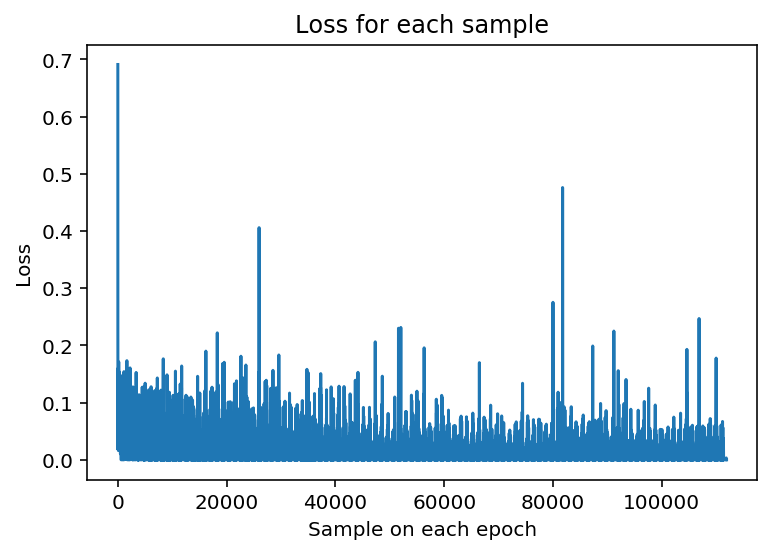

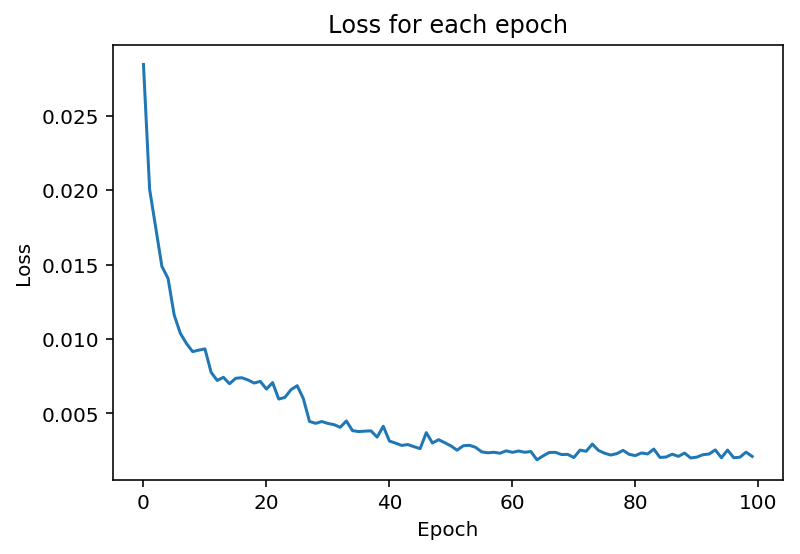

In [3]:
import matplotlib.pyplot as plt

plt.plot(range(len(l)), l)
plt.title("Loss for each sample")
plt.ylabel("Loss")
plt.xlabel("Sample on each epoch")
plt.show()

plt.plot(range(len(ll)), ll)
plt.title("Loss for each epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [4]:
notes = []  # Will contain a sequence of the predicted notes
x = notes_encoded[2:2+seq_len, :, :]  # Input notes, in this case only the first note (seq_len=1)
notes.append(x)
h_state = torch.zeros(1, 1, 89).float()
c_state = torch.zeros(1, 1, 89).float()
for step in range(2, 100):  # Let's get 100 time_steps
    chosen = False  # To account for when no dimension's probability is bigger than 0.9
    y_pred, h_c_state = net(x, (h_state, c_state))  
    h_state, c_state = h_c_state[0].data, h_c_state[1].data
    y_pred = y_pred.data
    choose = torch.zeros(y_pred.shape)  # Coverts the probabilities 
    for idx in range(y_pred.shape[2]):  # to the actual notes vectors
        if y_pred[:, :, idx] > 0.9:
            choose[:, :, idx] = 1
            chosen = True
    if not chosen:
        choose[:, :, np.argmax(y_pred)] = 1
        print(y_pred[:, :, np.argmax(y_pred)])  # Maximum probability out of all components
    x = choose  # Uses the output of the last time_step as the input for the next time_step
    notes.append(choose)

tensor([[0.5261]])
tensor([[0.8662]])
tensor([[0.0892]])
tensor([[0.0152]])
tensor([[0.5298]])
tensor([[0.6001]])
tensor([[0.5911]])
tensor([[0.3710]])
tensor([[0.4045]])
tensor([[0.5552]])
tensor([[0.5231]])
tensor([[0.8810]])
tensor([[0.7694]])
tensor([[0.6502]])
tensor([[0.4234]])
tensor([[0.6553]])
tensor([[0.4970]])
tensor([[0.8061]])
tensor([[0.6527]])
tensor([[0.4510]])
tensor([[0.6058]])
tensor([[0.6409]])
tensor([[0.6210]])
tensor([[0.6607]])
tensor([[0.7000]])
tensor([[0.8680]])
tensor([[0.7382]])
tensor([[0.8237]])
tensor([[0.7209]])
tensor([[0.4718]])
tensor([[0.4969]])
tensor([[0.7152]])
tensor([[0.6814]])


In [5]:
# Gets the notes into the correct NumPy array shape
gen_notes = np.empty((len(notes), 89))
for idx, nt in enumerate(notes):
    gen_notes[idx] = nt.numpy()[0]

In [6]:
gen_midi = decode(gen_notes, time_step=0.25)
gen_midi.write("midi", "come_on.mid")

'come_on.mid'

In [7]:
gen_midi[:10].show("text")

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.tempo.MetronomeMark andante Quarter=74>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Note G>
{0.25} <music21.note.Note B>
{0.5} <music21.chord.Chord D4 D5>
{0.75} <music21.note.Note G>
{1.0} <music21.note.Note B>
{1.25} <music21.note.Note D>


In [8]:
bach[0][:10].show("text")

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.tempo.MetronomeMark andante Quarter=74.0>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Rest rest>
{0.5} <music21.note.Note G>
{0.75} <music21.note.Note C>
{1.0} <music21.tempo.MetronomeMark Quarter=75.5>
{1.0} <music21.note.Note E>
{1.25} <music21.tempo.MetronomeMark andante Quarter=74.0>


This gets the first notes right, but when we need a longer sequence info to predict and change types of sequences, it fails. Let's use a longer sequence length. 14 seems like a good choice looking at the original piece

In [9]:
net = LSTMMusic(89, 89)
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_func = nn.BCELoss()  # Because we are using sigmoid and not softmax, BCELoss is the right choice
h_state = torch.zeros(1, 1, 89).float()  # Initializes the hidden
c_state = torch.zeros(1, 1, 89).float()  # and cell states
seq_len = 14  # We will take as input the 14 previous notes
l = []  # Stores the loss per sequence
lll = []  # Idem, but will be set to [] after each epoch for ll
ll = []  # Stores the mean loss per epoch
wait_10 = 0  # We will halve the learning rate if the loss does not decrease in the last 10 epochs
for epoch in range(100):
    print("---------- epoch number:", epoch, "----------")
    for step in range(notes_encoded.shape[0]//seq_len - 1):
        x = notes_encoded[step:seq_len+step, :, :]  # We take as input the last seq_len notes
        x.requires_grad = True
        y = notes_encoded[step+seq_len:step+seq_len*2, :, :]  # Uses the whole next sequence to get the loss
        #y = notes_encoded[step+seq_len, :, :]                # Uses only the next note after input sequence to get the loss
        y_pred, h_c_state = net(x, (h_state, c_state))  
        #y_pred = y_pred[0]                                      # Uses only the next note after input sequence to get the loss
        # y_pred shape: [seq_len, batch_size, hidden_size]
        h_state, c_state = h_c_state[0].data, h_c_state[1].data  # repack the hidden state, break the connection from last iteration
        loss = loss_func(y_pred, y)
        l.append(loss.data)
        lll.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ll.append(np.mean(lll))
    print("           loss:", ll[-1])
    if ll[-1] > np.mean(ll[::-1][:10]) and wait_10 >= 10:  # We decrease the learning rate by half
        print("Halving learning rate from", lr, "to", lr/2)  # When the loss stops decreasing
        lr = lr/2
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        wait_10 = 0
    lll = []
    wait_10 += 1

---------- epoch number: 0 ----------
           loss: 0.074073255
---------- epoch number: 1 ----------
           loss: 0.041022558
---------- epoch number: 2 ----------
           loss: 0.0422484
---------- epoch number: 3 ----------
           loss: 0.04279968
---------- epoch number: 4 ----------
           loss: 0.042780172
---------- epoch number: 5 ----------
           loss: 0.04241855
---------- epoch number: 6 ----------
           loss: 0.04097297
---------- epoch number: 7 ----------
           loss: 0.036657315
---------- epoch number: 8 ----------
           loss: 0.030610079
---------- epoch number: 9 ----------
           loss: 0.021538643
---------- epoch number: 10 ----------
           loss: 0.017131606
---------- epoch number: 11 ----------
           loss: 0.013448768
---------- epoch number: 12 ----------
           loss: 0.013366033
---------- epoch number: 13 ----------
           loss: 0.012835024
---------- epoch number: 14 ----------
           loss: 0.01346

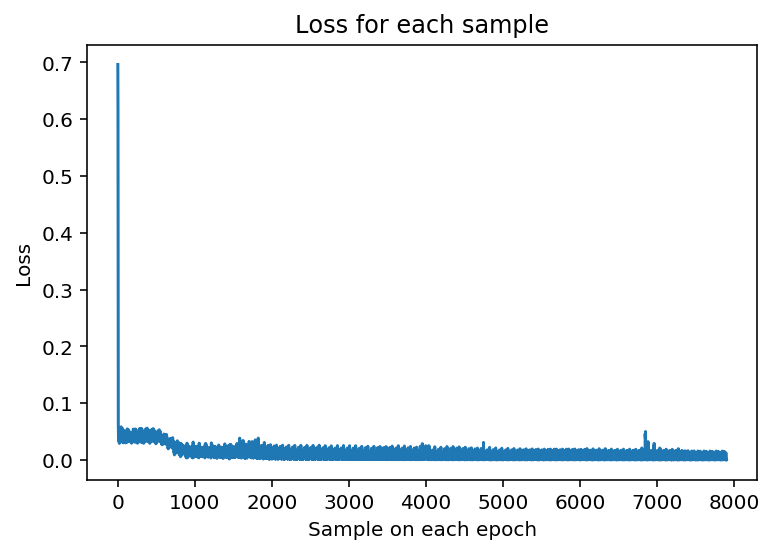

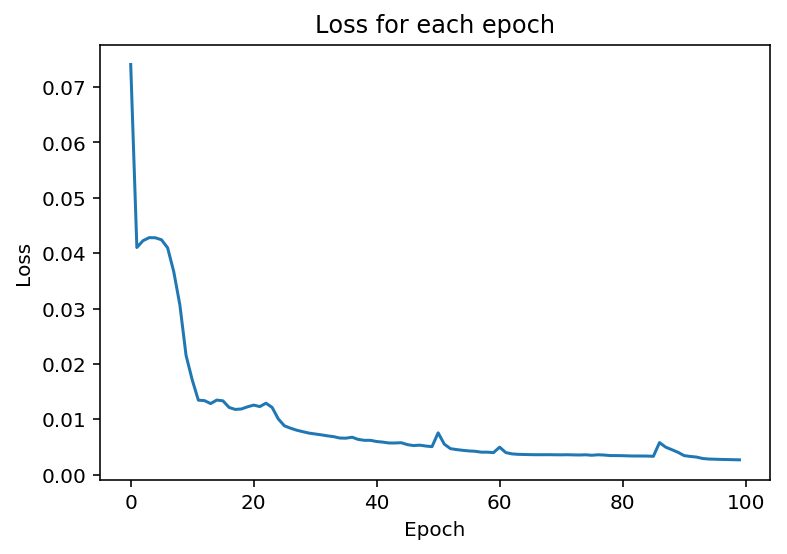

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(l)), l)
plt.title("Loss for each sample")
plt.ylabel("Loss")
plt.xlabel("Sample on each epoch")
plt.show()

plt.plot(range(len(ll)), ll)
plt.title("Loss for each epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [11]:
x = notes_encoded[step:seq_len+step, :, :]
y_pred, h_c_state = net(x, (h_state, c_state))

In [12]:
y_pred.shape

torch.Size([14, 1, 89])

In [13]:
x.shape

torch.Size([14, 1, 89])

In [14]:
notes = []
x = notes_encoded[2:2+seq_len, :, :]
notes.append(x)
h_state = torch.zeros(1, 1, 89).float()
c_state = torch.zeros(1, 1, 89).float()
for step in range(3, 100):
    chosen = False
    y_pred, h_c_state = net(x, (h_state, c_state))  
    h_state, c_state = h_c_state[0].data, h_c_state[1].data
    y_pred = y_pred.data
    choose = torch.zeros(y_pred.shape)
    for seq_idx, nt in enumerate(y_pred):
        for idx in range(y_pred.shape[2]):
            if nt[:, idx] > 0.9:
                choose[seq_idx, :, idx] = 1
                chosen = True
        if not chosen:
            choose[seq_idx, :, np.argmax(nt)] = 1
        chosen = False
    x = choose
    notes.append(choose)

In [15]:
notes[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]])

In [16]:
notes[0][0].numpy().shape

(1, 89)

In [17]:
gen_notes = np.empty((seq_len*len(notes), 89))
for idx_seq, seq in enumerate(notes):
    for idx_nt, nt in enumerate(seq):
        gen_notes[idx_seq*seq_len+idx_nt] = nt[0].numpy()

In [18]:
gen_midi_14 = decode(gen_notes, time_step=0.25)
gen_midi_14.write("midi", "come_on_14.mid")

'come_on_14.mid'

This looks better, but I think I'm missing some fundamental concept... Need to read and think more on all of this.

In [19]:
gen_midi_14[:20].show("text")

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.tempo.MetronomeMark andante Quarter=74>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Note G>
{0.25} <music21.note.Note C>
{0.5} <music21.note.Note E>
{0.75} <music21.note.Note G>
{1.0} <music21.note.Note C>
{1.25} <music21.note.Note E>
{1.5} <music21.note.Rest rest>
{2.0} <music21.note.Note G>
{2.25} <music21.note.Note C>
{2.5} <music21.note.Note E>
{2.75} <music21.note.Note G>
{3.0} <music21.note.Note C>
{3.25} <music21.note.Note E>
{3.5} <music21.note.Note E>
{3.75} <music21.note.Note A>
{4.0} <music21.note.Note A>


In [20]:
bach[0][:20].show("text")

{0.0} <music21.instrument.Piano Piano>
{0.0} <music21.tempo.MetronomeMark andante Quarter=74.0>
{0.0} <music21.key.Key of C major>
{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.note.Rest rest>
{0.5} <music21.note.Note G>
{0.75} <music21.note.Note C>
{1.0} <music21.tempo.MetronomeMark Quarter=75.5>
{1.0} <music21.note.Note E>
{1.25} <music21.tempo.MetronomeMark andante Quarter=74.0>
{1.25} <music21.note.Note G>
{1.5} <music21.note.Note C>
{1.75} <music21.note.Note E>
{2.0} <music21.note.Rest rest>
{2.5} <music21.note.Note G>
{2.75} <music21.note.Note C>
{3.0} <music21.note.Note E>
{3.25} <music21.tempo.MetronomeMark Quarter=75.0>
{3.25} <music21.note.Note G>
{3.5} <music21.note.Note C>
